<a href="https://colab.research.google.com/github/Mv0sKff/MyDeepLearning/blob/main/week_6/Assignemnt_stock-price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Stock Price Prediction

## Data
We are using data from a larger collection of stock data from [Kaggle](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).


## Setup

In [1]:
import numpy as np
import random
import pandas as pd
from pylab import mpl, plt
%matplotlib inline

import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable


## Load data

In [2]:
#get data from GitHub -> https://github.com/keuperj/DATA
!git clone https://github.com/keuperj/DATA.git

Cloning into 'DATA'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 126 (delta 11), reused 39 (delta 11), pack-reused 87 (from 1)
Receiving objects: 100% (126/126), 185.56 MiB | 10.92 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (86/86), done.


In [3]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("DATA/{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

<ipython-input-4-ddf1f5c272a1>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='pad', inplace=True)


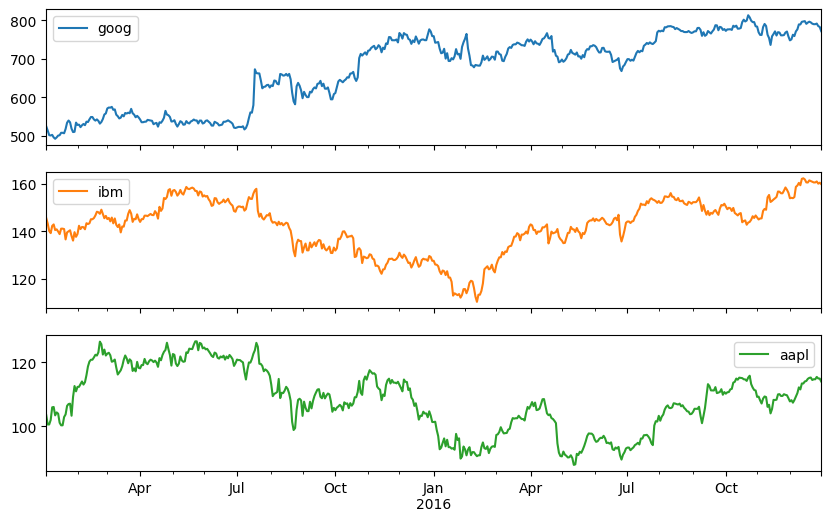

In [4]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad', inplace=True)
df.plot(figsize=(10, 6), subplots=True);

In [5]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


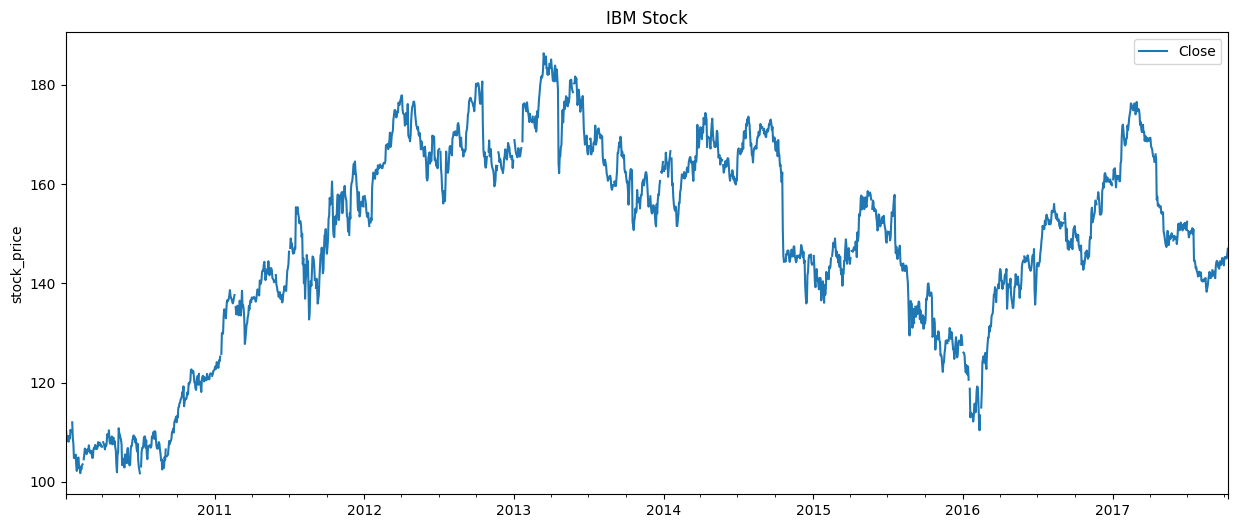

In [6]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')
df1=pd.DataFrame(index=dates)
df_ibm=pd.read_csv("DATA/ibm.us.txt", parse_dates=True, index_col=0)
df_ibm=df1.join(df_ibm)
df_ibm[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("IBM Stock")
plt.show()

In [7]:
df_ibm=df_ibm[['Close']]
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2028 entries, 2010-01-04 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1958 non-null   float64
dtypes: float64(1)
memory usage: 31.7 KB


In [8]:
#some pre-processing
df_ibm=df_ibm.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1,1))


<ipython-input-8-b8ae6ac2b06d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ibm=df_ibm.fillna(method='ffill')


In [9]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1574, 59, 1)
y_train.shape =  (1574, 1)
x_test.shape =  (394, 59, 1)
y_test.shape =  (394, 1)


In [10]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [11]:
y_train.size(),x_train.size()

(torch.Size([1574, 1]), torch.Size([1574, 59, 1]))

## Assingment: Build LSTM
* build a PyTorch LSTM model
* train and evaluate
* plot pricition and true stock valaues

In [24]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        #self.num_layers = output_dim
        self.num_layers = num_layers
        #self.input_size = input_dim
        self.hidden_size = hidden_dim

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(self.hidden_size*self.num_layers, self.num_layers)

    def forward(self, x):
        #init input
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size*num_layers)

        out = self.fc(h_out)

        return out

In [19]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

In [25]:
num_epochs = 2000
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
  x_train = x_train.to(device)
  y_train = y_train.to(device)
  outputs = lstm(x_train)
  optimizer.zero_grad()

  # obtain the loss function
  loss = criterion(outputs, y_train)

  loss.backward()

  optimizer.step()
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1574, 1])) that is different to the input size (torch.Size([1574, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.27675
Epoch: 100, loss: 0.15629
Epoch: 200, loss: 0.20580
Epoch: 300, loss: 0.19292
Epoch: 400, loss: 0.18132
Epoch: 500, loss: 0.13540
Epoch: 600, loss: 0.12437
Epoch: 700, loss: 0.09526
Epoch: 800, loss: 0.10606
Epoch: 900, loss: 0.09323
Epoch: 1000, loss: 0.08892
Epoch: 1100, loss: 0.08499
Epoch: 1200, loss: 0.07895
Epoch: 1300, loss: 0.07577
Epoch: 1400, loss: 0.07019
Epoch: 1500, loss: 0.07139
Epoch: 1600, loss: 0.06673
Epoch: 1700, loss: 0.07179
Epoch: 1800, loss: 0.06774
Epoch: 1900, loss: 0.07371


<ipython-input-50-cc1774747f3e>:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


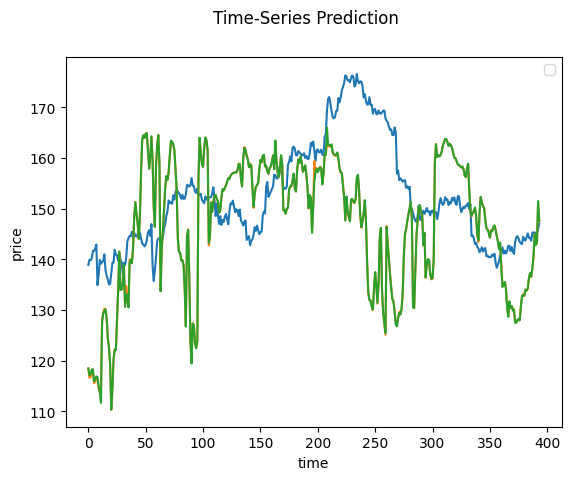

In [50]:
lstm.eval()

x_test = x_test.to(device)
train_predict = lstm(x_test)

data_predict = train_predict.cpu().data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

#plt.axvline(x=len(x_train), c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

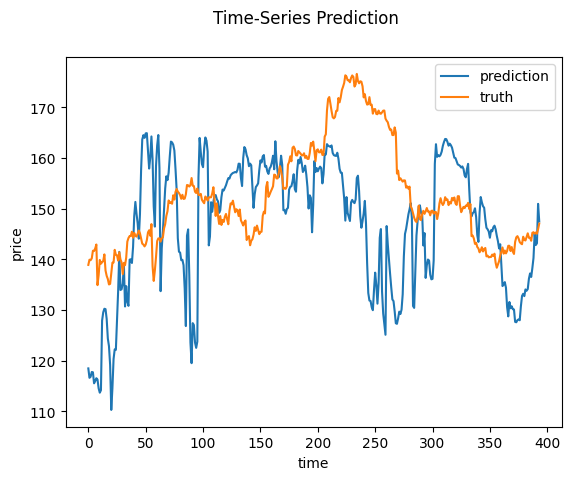

In [64]:
plt.plot(data_predict.T[0], label='prediction')

plt.plot(scaler.inverse_transform(y_test), label='truth')

plt.suptitle('Time-Series Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()